# PROJECT NAME: Compare Q-Learning and MiniMax(Alpha/Beta) in Tic-Tac-Toe

# **Project Workflow**




1. **Introduction**
    * Purpose: Briefly describe the project purpose (e.g., comparing reinforcement learning and planning/searching algorithms for game playing).
    * Algorithms: Introduce the algorithms you'll implement and compare (e.g., Q-learning, DQN, Minimax, Alpha-beta, MCTS, Random).
    * Game: Mention the game you chose for evaluation (e.g., Tic-Tac-Toe or another game).

2. **Import Libraries**
    * Import necessary libraries like numpy, matplotlib, tensorflow.

3. **Experimental Methods**
    * Workflow
    * Game Setup: Define Tic-Tac-Toe game environment
    * Evaluation Metrix  (win rate, average reward, training time,convergence rate, and decision time)

4. **Implement Random Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Random will serve as a baseline

5. **Implement Minimax Algorithms**
    * Algorithms Description
    * Parameters Analysis (Set the parameters planned to vary)
    * Conclusion(Analyze how changing parameters impacted the agents' performance)

6. **Implement MCTS Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion

7. **Implement Q-learning Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion

8. **Implement DQN Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion


9. **Discussion and Analysis**
    * Visual Performance Comparison (Use graphs and tables to compare the performance of different algorithms. Show win rates, decision time, and convergence rate.)
    * Compare the strengths and weaknesses of RL (e.g., Q-learning, DQN) vs. planning algorithms (Minimax, MCTS).

10. **Conclusion**
    * Summarize the key findings and suggest potential improvements or future work

11. **References**


# **Step1: Introduction**

# **Step 2. Import Libraries**



In [26]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output

from tqdm import tqdm
import pickle, math, logging, random, time
import pandas as pd


# **Step 3. Experimental Methods**


## 3.1 Game Setup
 Define Tic-Tac-Toe game environment

In [27]:


# Constants for board size
ROWS, COLS = 3, 3

# Setting up the logger for the game
name = 'qlvsran'
logger = logging.getLogger(name)
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(f'{name}.log')
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)


class Board:
    def __init__(self, dimensions=(3, 3)):
        # Initialize a Tic-Tac-Toe board with the given dimensions
        self.dimensions = dimensions
        self.board = np.zeros(self.dimensions, dtype=int)  # Initialize the board with zeros (empty spots)
        self.turn = 1  # Player 1 starts the game

    def copy(self):
        # Return a deep copy of the board
        new_board = Board(self.dimensions)
        new_board.board = np.copy(self.board)
        new_board.turn = self.turn
        return new_board

    def possible_moves(self):
        # Return a list of all possible moves (empty positions on the board)
        positions = np.argwhere(self.board == 0)
        return positions

    def push(self, action):
        # Make a move at the specified action (position)
        action = tuple(action)
        if self.board[action] == 0:
            self.board[action] = self.turn
            # Change turn: If Player 1, switch to Player 2, and vice versa
            self.turn = 2 if self.turn == 1 else 1
        else:
            raise ValueError('Invalid move: Position already taken')

    def result(self):
        # Check if there is a winner, a draw, or if the game is still ongoing
        for i in range(3):
            # Check rows for a winner
            if np.all(self.board[i, :] == 1):
                return 1  # Player 1 wins
            if np.all(self.board[i, :] == 2):
                return 2  # Player 2 wins
            # Check columns for a winner
            if np.all(self.board[:, i] == 1):
                return 1  # Player 1 wins
            if np.all(self.board[:, i] == 2):
                return 2  # Player 2 wins
        # Check diagonals for a winner
        if np.all(np.diag(self.board) == 1):
            return 1  # Player 1 wins
        if np.all(np.diag(self.board) == 2):
            return 2  # Player 2 wins
        if np.all(np.diag(np.fliplr(self.board)) == 1):
            return 1  # Player 1 wins
        if np.all(np.diag(np.fliplr(self.board)) == 2):
            return 2  # Player 2 wins
        # If all positions are filled and no winner, it's a draw
        if np.all(self.board != 0):
            return 0  # Draw
        # Game is still ongoing
        return None

    def get_mark_at_position(self, position):
        # Return the mark (player number) at the given position
        position = tuple(position)
        return self.board[position]

    def set_mark(self, position, player):
        # Place the player's mark at the given position
        position = tuple(position)
        if self.board[position] == 0:
            self.board[position] = player
        else:
            raise ValueError('Invalid move: Position already taken')



## 3.2 Evaluation Metrix  

(win rate, average reward, training time,convergence rate, and decision time)

In [28]:


class TicTacToe:
    def __init__(self, p1, p2):
        # Initialize the game with two players and a board
        self.board = Board(dimensions=(ROWS, COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None

    def getBoard(self):
        # Return a hashed version of the board as a string for state tracking
        self.boardHash = str(self.board.board.flatten())
        return self.boardHash

    def getWinner(self):
        # Return the result of the game (1 if Player 1 wins, 2 if Player 2 wins, 0 for draw, or None if ongoing)
        return self.board.result()

    def getPositions(self):
        # Get a list of all available positions where a move can be made
        return self.board.possible_moves()

    def setReward(self):
        # Assign rewards based on the game result
        result = self.getWinner()
        if result == 1:
            self.p1.setReward(1)  # Player 1 wins
            self.p2.setReward(0)  # Player 2 loses
        elif result == 2:
            self.p1.setReward(0)  # Player 1 loses
            self.p2.setReward(1)  # Player 2 wins
        else:
            # Assign draw rewards
            self.p1.setReward(0.1)  # Draw reward for Player 1
            self.p2.setReward(0.5)

    def reset(self):
        # Reset the game state for a new game
        self.board = Board()
        self.boardHash = None
        self.isEnd = False

    def setMove(self, action):
        # Execute a move on the board
        self.board.push(action)

    def train(self, episodes=1000):
        # Train the players over a number of episodes
        for i in tqdm(range(episodes)):
            while not self.isEnd:
                # Player 1's turn
                positions = self.getPositions()
                p1_action = self.p1.getMove(positions, self.board)
                self.setMove(p1_action)
                board_hash = self.getBoard()
                self.p1.setState(board_hash)

                win = self.getWinner()
                if win is not None:
                    self.setReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                # Player 2's turn
                positions = self.getPositions()
                p2_action = self.p2.getMove(positions, self.board)
                self.setMove(p2_action)
                board_hash = self.getBoard()
                self.p2.setState(board_hash)

                win = self.getWinner()
                if win is not None:
                    self.setReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

    def update_stats(self, winner, move_count, p1_decision_time, p2_decision_time, stats):
        # Update the game statistics after a round
        if stats is None:
            return

        if winner == self.p1.name:
            stats['p1_wins'] += 1
            stats['p1_rewards'].append(1)
            stats['p2_rewards'].append(0)
        elif winner == self.p2.name:
            stats['p2_wins'] += 1
            stats['p1_rewards'].append(0)
            stats['p2_rewards'].append(1)
        else:
            stats['draws'] += 1
            stats['p1_rewards'].append(0.2)
            stats['p2_rewards'].append(0.2)

        stats['moves'].append(move_count)
        stats['p1_times'].append(p1_decision_time)
        stats['p2_times'].append(p2_decision_time)

    def handle_win(self, winner, check):
        # Handle win display and reset the game
        if check:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.text(0.5, 0.5, f"{winner} wins!", fontsize=30, ha='center', va='center')
            plt.axis('off')
            plt.show()
        logger.warning(f"{winner}")
        self.reset()
        return winner

    def handle_draw(self, check):
        # Handle draw scenario and reset the game
        if check:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.text(0.5, 0.5, "Tie Game", fontsize=30, ha='center', va='center')
            plt.axis('off')
            plt.show()
        logger.warning("tie")
        self.reset()
        return "tie"

    def play(self, check=False, stats=None):
        # Run a single game between two players
        move_count = 0
        p1_decision_time = 0
        p2_decision_time = 0

        while not self.isEnd:
            # Player 1's move
            start_time = time.time()
            positions = self.getPositions()
            p1_action = self.p1.getMove(positions, self.board)
            self.setMove(p1_action)
            move_count += 1
            p1_decision_time += (time.time() - start_time) * 1000  # Record decision time in ms

            clear_output()
            if check:
                self.showBoard(self.p1.name)

            win = self.getWinner()
            if win is not None:
                if win == 1:
                    winner = self.p1.name
                    self.update_stats(winner, move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_win(winner, check)
                else:
                    self.update_stats("tie", move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_draw(check)

            # Player 2's move
            start_time = time.time()
            positions = self.getPositions()
            p2_action = self.p2.getMove(positions, self.board)
            self.setMove(p2_action)
            move_count += 1
            p2_decision_time += (time.time() - start_time) * 1000  # Record decision time in ms

            clear_output()
            if check:
                self.showBoard(self.p2.name)

            win = self.getWinner()
            if win is not None:
                if win == 2:
                    winner = self.p2.name
                    self.update_stats(winner, move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_win(winner, check)
                else:
                    self.update_stats("tie", move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_draw(check)



    def evaluate(self, episodes=100, check=False):
        # Evaluate the performance of both players over multiple games
        stats = {
            'p1_wins': 0,
            'p2_wins': 0,
            'draws': 0,
            'p1_rewards': [],
            'p2_rewards': [],
            'moves': [],
            'p1_times': [],
            'p2_times': []
        }

        for _ in range(episodes):
            self.play(check=check, stats=stats)

        # Calculate statistics
        win_rate_p1 = (stats['p1_wins'] / episodes) * 100
        win_rate_p2 = (stats['p2_wins'] / episodes) * 100
        draw_rate = (stats['draws'] / episodes) * 100
        avg_reward_p1 = np.mean(stats['p1_rewards'])
        avg_reward_p2 = np.mean(stats['p2_rewards'])
        reward_p1 = np.sum(stats['p1_rewards'])
        reward_p2 = np.sum(stats['p2_rewards'])
        avg_moves = np.mean(stats['moves'])
        avg_decision_time_p1 = np.mean(stats['p1_times'])
        avg_decision_time_p2 = np.mean(stats['p2_times'])
        variance_of_reward_p1 = np.var(stats['p1_rewards'])
        variance_of_reward_p2 = np.var(stats['p2_rewards'])

        return {
            "Win Rate P1 (%)": win_rate_p1,
            "Win Rate P2 (%)": win_rate_p2,
            "Draw Rate (%)": draw_rate,
            "Avg Reward P1": avg_reward_p1,
            "Avg Reward P2": avg_reward_p2,
            "Reward P1": reward_p1,
            "Reward P2": reward_p2,
            "Avg Moves": avg_moves,
            "Avg Decision Time P1 (ms)": avg_decision_time_p1,
            "Avg Decision Time P2 (ms)": avg_decision_time_p2,
            "Variance of Reward P1": variance_of_reward_p1,
            "Variance of Reward P2": variance_of_reward_p2
        }


    def plotBoard(self, name):
        # Plot the current board state
        symbols = {1: 'X', 2: 'O'}
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_aspect('equal')

        for i in range(3):
            for j in range(3):
                player = self.board.get_mark_at_position((i, j))
                symbol = symbols.get(player, ' ')
                color = 'red' if symbol == 'O' else 'black'
                ax.text(j + 0.5, 2.5 - i, symbol, ha='center', va='center', fontsize=50, color=color, family='monospace')

        for x in range(1, 3):
            ax.axvline(x=x, color='black', linestyle='-', linewidth=2)
        for y in range(1, 3):
            ax.axhline(y=y, color='black', linestyle='-', linewidth=2)

        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.title(f"{name} played the Turn")
        plt.show(block=False)
        plt.pause(0.8)
        plt.close()


    def showBoard(self, name):
        # Display the board
        self.plotBoard(name)


# **Step 4. Random Algorithm**

## 4.1 Algorithm Description

explain something

In [29]:
class RandomPlayer:
    def __init__(self, name='random'):
        # Initialize the RandomPlayer with a given name (default is 'random')
        self.name = name

    def getMove(self, positions, board):
        # Select a random move from the list of possible positions (moves)
        return random.choice(positions)

    def setReward(self, reward):
        # Random player doesn't learn from rewards, so this method is empty
        pass

    def setState(self, state):
        # Random player doesn't maintain state information, so this method is empty
        pass

    def reset(self):
        # Random player doesn't need to reset its state, so this method is empty
        pass

In [30]:
# Function to plot results with two separate charts
def plot_tictactoe_results(df_results, xlabel="Episode"):
    """
    Plots the performance metrics of the Tic-Tac-Toe experiment in two side-by-side charts.

    Parameters:
    - df_results: DataFrame containing experiment results.
    """

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Adjust index to start from 1
    x_values = df_results.index + 1

    # First plot: Plot Win Rate, Draw Rate
    ax1.plot(x_values, df_results['Win Rate P1 (%)'], marker='o', color='blue', label='Win Rate P1 (%)')
    ax1.plot(x_values, df_results['Win Rate P2 (%)'], marker='s', color='green', label='Win Rate P2 (%)')
    ax1.plot(x_values, df_results['Draw Rate (%)'], marker='^', color='orange', label='Draw Rate (%)')

    # Add legends, labels, and grid to the first chart
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Win/Draw Rate (%)')
    ax1.legend(loc='center right')
    ax1.grid(True)
    ax1.set_title('Win Rate and Draw Rate')

    # Second plot: Plot Avg Reward, Variance of Reward
    ax2.plot(x_values, df_results['Avg Reward P1'], marker='D', color='purple', label='Avg Reward P1')
    ax2.plot(x_values, df_results['Variance of Reward P1'], marker='v', color='brown', label='Variance of Reward P1')

    # Add legends, labels, and grid to the second chart
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('Avg Reward / Variance')
    ax2.legend(loc='center left')
    ax2.grid(True)
    ax2.set_title('Avg Reward and Variance of Reward')

    # Create a right y-axis on the second chart for decision Time
    ax3 = ax2.twinx()  # Create a shared x-axis for the second y-axis
    ax3.plot(x_values, df_results['Avg Decision Time P1 (ms)'], marker='x', color='red', label='Avg Decision Time P1 (ms)')
    ax3.set_ylabel('Avg Decision Time P1 (ms)', color='red')
    ax3.legend(loc='center right')

    # Adjust layout and show the charts
    plt.tight_layout()
    plt.show()


## 4.2 Parameters Analysis

### 4.2.1 Parameter1 change Analysis

   Win Rate P1 (%)  Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  \
0             55.5             33.0           11.5          0.578   
1             58.5             30.5           11.0          0.607   
2             56.0             32.0           12.0          0.584   
3             56.5             30.5           13.0          0.591   
4             56.5             29.5           14.0          0.593   

   Avg Reward P2  Reward P1  Reward P2  Avg Moves  Avg Decision Time P1 (ms)  \
0          0.353      115.6       70.6      7.640                   0.527308   
1          0.327      121.4       65.4      7.445                   0.507095   
2          0.344      116.8       68.8      7.550                   0.427903   
3          0.331      118.2       66.2      7.485                   0.440662   
4          0.323      118.6       64.6      7.675                   0.349913   

   Avg Decision Time P2 (ms)  Variance of Reward P1  Variance of Reward P2  
0                   0.38136

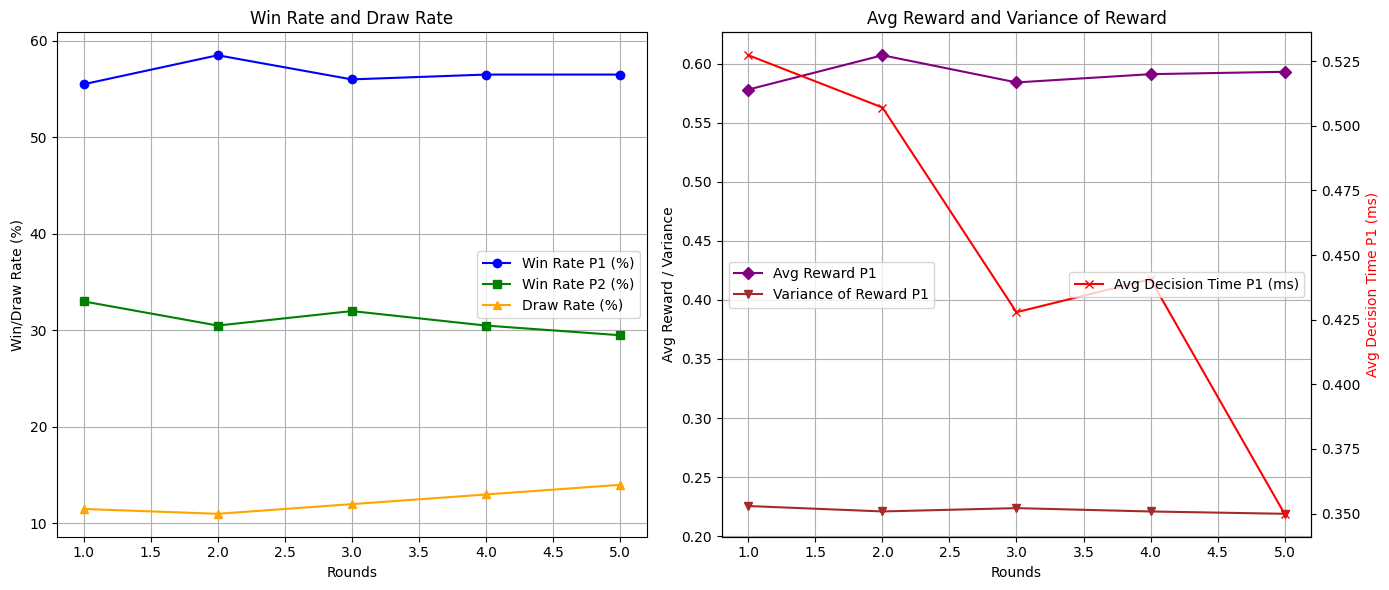

In [31]:



# Example of usage
random_player_1 = RandomPlayer(name="random1")
random_player_2 = RandomPlayer(name="random2")
# Run the experiment and store results in a DataFrame
results_all = []
for i in range(5):
    ttt = TicTacToe(random_player_1, random_player_2)
    results_random_vs_random = ttt.evaluate(episodes=200)
    results_all.append(results_random_vs_random)

df_results_all = pd.DataFrame(results_all)

print(df_results_all)
# Plot the results
plot_tictactoe_results(df_results_all,xlabel="Rounds")

In [32]:
# Example of usage
random_player_1 = RandomPlayer(name="random1")
random_player_2 = RandomPlayer(name="random2")

# RandomPlayer vs RandomPlayer (10 episodes)
ttt = TicTacToe(random_player_1, random_player_2)
results_random_vs_random = ttt.evaluate(episodes=200)
print("RandomPlayer vs RandomPlayer:", results_random_vs_random)


# Convert results to a DataFrame and display as a table
df_results = pd.DataFrame([results_random_vs_random])


print("Results of RandomPlayer vs RandomPlayer:")
df_results

RandomPlayer vs RandomPlayer: {'Win Rate P1 (%)': 56.00000000000001, 'Win Rate P2 (%)': 30.0, 'Draw Rate (%)': 14.000000000000002, 'Avg Reward P1': 0.5880000000000001, 'Avg Reward P2': 0.32800000000000007, 'Reward P1': 117.60000000000001, 'Reward P2': 65.60000000000001, 'Avg Moves': 7.73, 'Avg Decision Time P1 (ms)': 0.42940497398376465, 'Avg Decision Time P2 (ms)': 0.3304266929626465, 'Variance of Reward P1': 0.21985600000000002, 'Variance of Reward P2': 0.198016}
Results of RandomPlayer vs RandomPlayer:


,Win Rate P1 (%),Win Rate P2 (%),Draw Rate (%),Avg Reward P1,Avg Reward P2,Reward P1,Reward P2,Avg Moves,Avg Decision Time P1 (ms),Avg Decision Time P2 (ms),Variance of Reward P1,Variance of Reward P2
0,56.0,30.0,14.0,0.588,0.328,117.6,65.6,7.73,0.429405,0.330427,0.219856,0.198016


**Show Plt**

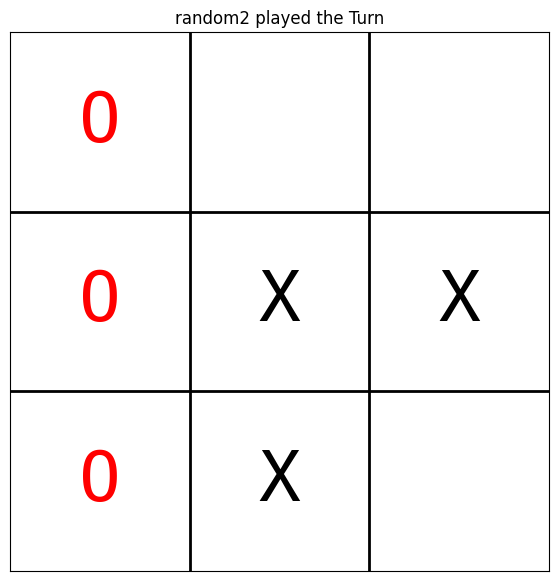

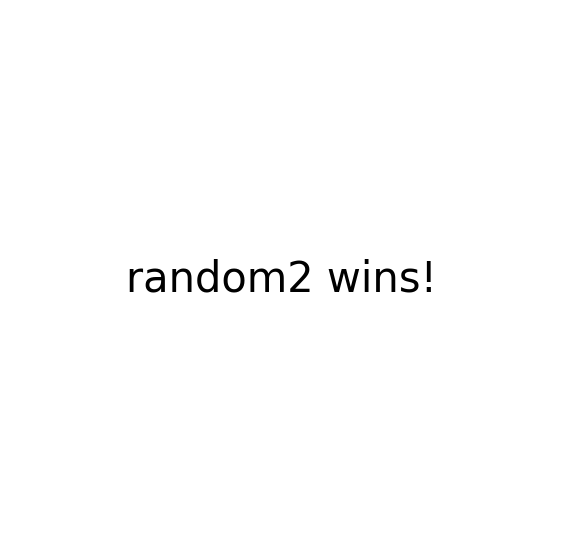

'random2'

In [33]:

ttt = TicTacToe(random_player_1, random_player_2)
ttt.play(check=True)

## 4.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 5. Minimax Algorithm**

## 5.1 Algorithm Description

explain something

In [58]:

class MinimaxPlayer:
    # Class-level cache shared among all instances
    global_cache = {}
    def __init__(self, name='minimax', use_alpha_beta=True, max_depth=9, use_cache=True):
        # Initialize the MinimaxPlayer with options for alpha-beta pruning and maximum depth for search
        self.name = name
        self.use_alpha_beta = use_alpha_beta  # Whether to use alpha-beta pruning
        if not use_alpha_beta:
            max_depth = 9  # If alpha-beta pruning is not used, set a default depth of 9

        self.max_depth = max_depth  # Maximum depth for the minimax search
        self.use_cache = use_cache  # Whether to use the cache or not

    def getMove(self, positions, board):
        # Create a hash of the positions for caching
        positions_hash = tuple(map(tuple, positions))

        # Check if the result for this positions hash is already cached
        if self.use_cache and positions_hash in MinimaxPlayer.global_cache:
            return MinimaxPlayer.global_cache[positions_hash]

        # If the board is empty (i.e., at the start of the game), choose a random move
        if len(positions) == 9:  # 9 empty positions indicate the board is empty
            return random.choice(positions)

        best_move = None
        # Maximizing for player 1 and minimizing for player 2
        best_score = -float('inf') if board.turn == 1 else float('inf')

        for move in positions:
            new_board = board.copy()  # Make a copy of the current board state
            new_board.push(move)  # Push the move onto the new board

            # Perform minimax search, with or without alpha-beta pruning
            if self.use_alpha_beta:
                score = self.minimax(new_board, board.turn == 2, 1, -float('inf'), float('inf'))
            else:
                score = self.minimax(new_board, board.turn == 2, 1)

            # Maximizing player 1's score
            if board.turn == 1:  # Maximizing player
                if score > best_score:
                    best_score = score
                    best_move = move
            # Minimizing player 2's score
            else:  # Minimizing player
                if score < best_score:
                    best_score = score
                    best_move = move

        # Cache the result before returning
        self.cache[positions_hash] = best_move
        return best_move

    def minimax(self, board, is_maximizing, depth, alpha=None, beta=None):
        # Perform the minimax algorithm with optional alpha-beta pruning
        result = board.result()  # Check if there's a result (win/loss/draw)

        # If the game is over or max depth reached, return the score
        if result is not None or depth >= self.max_depth:
            return self.get_score(result)

        if is_maximizing:
            best_score = -float('inf')
            # Maximize the score for player 1
            for move in board.possible_moves():
                new_board = board.copy()
                new_board.push(move)
                score = self.minimax(new_board, False, depth + 1, alpha, beta)
                best_score = max(best_score, score)

                if self.use_alpha_beta:
                    alpha = max(alpha, best_score)
                    if beta is not None and beta <= alpha:  # Beta pruning
                        break
            return best_score
        else:
            best_score = float('inf')
            # Minimize the score for player 2
            for move in board.possible_moves():
                new_board = board.copy()
                new_board.push(move)
                score = self.minimax(new_board, True, depth + 1, alpha, beta)
                best_score = min(best_score, score)

                if self.use_alpha_beta:
                    beta = min(beta, best_score)
                    if alpha is not None and beta <= alpha:  # Alpha pruning
                        break
            return best_score

    def get_score(self, result):
        # Return the score for a given result (1 for Player 1 win, -10 for Player 2 win, 0 for draw)
        if result == 1:
            return 10  # Player 1 wins
        elif result == 2:
            return -10  # Player 2 wins
        else:
            return 0  # Draw or ongoing game

    def setReward(self, reward):
        # Minimax player does not learn from rewards, so this method is empty
        pass

    def setState(self, state):
        # Minimax player does not maintain state, so this method is empty
        pass

    def reset(self):
        # No need to reset state for MinimaxPlayer
        pass



class MinimaxPlayer_no_cache:
    def __init__(self, name='minimax', use_alpha_beta=True, max_depth=9):
        # Initialize the MinimaxPlayer with options for alpha-beta pruning and maximum depth for search
        self.name = name
        self.use_alpha_beta = use_alpha_beta  # Whether to use alpha-beta pruning
        if not use_alpha_beta:
          max_depth = 9  # If alpha-beta pruning is not used, set a default depth of 9

        self.max_depth = max_depth  # Maximum depth for the minimax search

    def getMove(self, positions, board):
        # If the board is empty (i.e., at the start of the game), choose a random move
        if len(positions) == 9:  # 9 empty positions indicate the board is empty
            return random.choice(positions)

        best_move = None
        # Maximizing for player 1 and minimizing for player 2
        best_score = -float('inf') if board.turn == 1 else float('inf')

        for move in positions:
            new_board = board.copy()  # Make a copy of the current board state
            new_board.push(move)  # Push the move onto the new board

            # Perform minimax search, with or without alpha-beta pruning
            if self.use_alpha_beta:
                score = self.minimax(new_board, board.turn == 2, 1, -float('inf'), float('inf'))
            else:
                score = self.minimax(new_board, board.turn == 2, 1)

            # Maximizing player 1's score
            if board.turn == 1:  # Maximizing player
                if score > best_score:
                    best_score = score
                    best_move = move
            # Minimizing player 2's score
            else:  # Minimizing player
                if score < best_score:
                    best_score = score
                    best_move = move

        return best_move

    def minimax(self, board, is_maximizing, depth, alpha=None, beta=None):
        # Perform the minimax algorithm with optional alpha-beta pruning
        result = board.result()  # Check if there's a result (win/loss/draw)

        # If the game is over or max depth reached, return the score
        if result is not None or depth >= self.max_depth:
            return self.get_score(result)

        if is_maximizing:
            best_score = -float('inf')
            # Maximize the score for player 1
            for move in board.possible_moves():
                new_board = board.copy()
                new_board.push(move)
                score = self.minimax(new_board, False, depth + 1, alpha, beta)
                best_score = max(best_score, score)

                if self.use_alpha_beta:
                    alpha = max(alpha, best_score)
                    if beta is not None and beta <= alpha:  # Beta pruning
                        break
            return best_score
        else:
            best_score = float('inf')
            # Minimize the score for player 2
            for move in board.possible_moves():
                new_board = board.copy()
                new_board.push(move)
                score = self.minimax(new_board, True, depth + 1, alpha, beta)
                best_score = min(best_score, score)

                if self.use_alpha_beta:
                    beta = min(beta, best_score)
                    if alpha is not None and beta <= alpha:  # Alpha pruning
                        break
            return best_score

    def get_score(self, result):
        # Return the score for a given result (1 for Player 1 win, -10 for Player 2 win, 0 for draw)
        if result == 1:
            return 10  # Player 1 wins
        elif result == 2:
            return -10  # Player 2 wins
        else:
            return 0  # Draw or ongoing game

    def setReward(self, reward):
        # Minimax player does not learn from rewards, so this method is empty
        pass

    def setState(self, state):
        # Minimax player does not maintain state, so this method is empty
        pass

    def reset(self):
        # No need to reset state for MinimaxPlayer
        pass




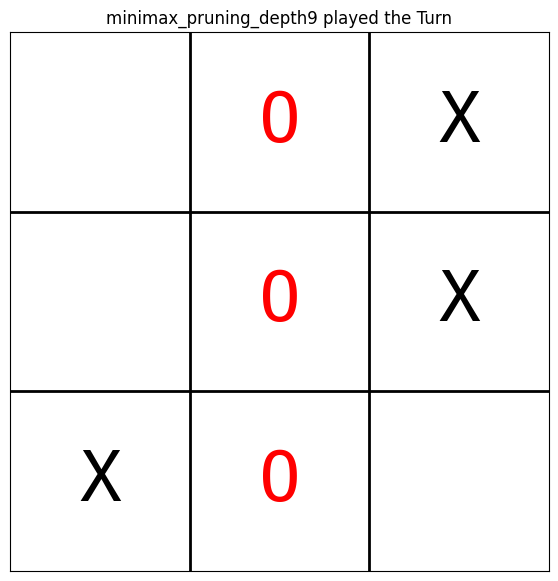

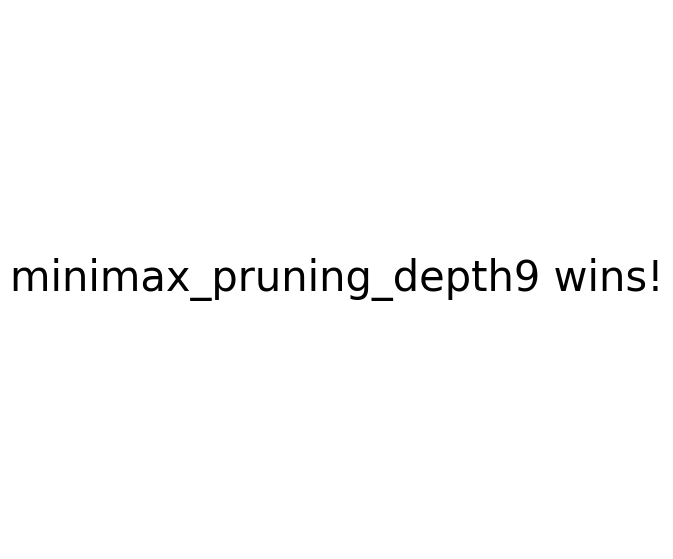

In [35]:
if 1==1 :
  random_player_1 = RandomPlayer(name="random1")
  minimax_player1 = MinimaxPlayer(name=f"minimax_pruning_depth1", use_alpha_beta=False)
  minimax_player3 = MinimaxPlayer(name=f"minimax_pruning_depth3", use_alpha_beta=True, max_depth=3)
  minimax_player9 = MinimaxPlayer(name=f"minimax_pruning_depth9", use_alpha_beta=True, max_depth=9)
  ttt = TicTacToe(random_player_1, minimax_player9)
  ttt.play(check=True)

## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

Comparison of MinimaxPlayer with Different Depths
   Win Rate P1 (%)  Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  \
0             78.0             17.0            5.0          0.790   
1             89.5              0.0           10.5          0.916   
2             93.5              2.0            4.5          0.944   
3             92.0              3.5            4.5          0.929   
4             97.5              0.0            2.5          0.980   
5             96.0              0.0            4.0          0.968   
6             96.0              0.0            4.0          0.968   
7             94.5              0.0            5.5          0.956   
8             98.0              0.0            2.0          0.984   

   Avg Reward P2  Reward P1  Reward P2  Avg Moves  Avg Decision Time P1 (ms)  \
0          0.180      158.0       36.0      6.390                   3.567926   
1          0.021      183.2        4.2      6.360                  27.881458   
2          0.029   

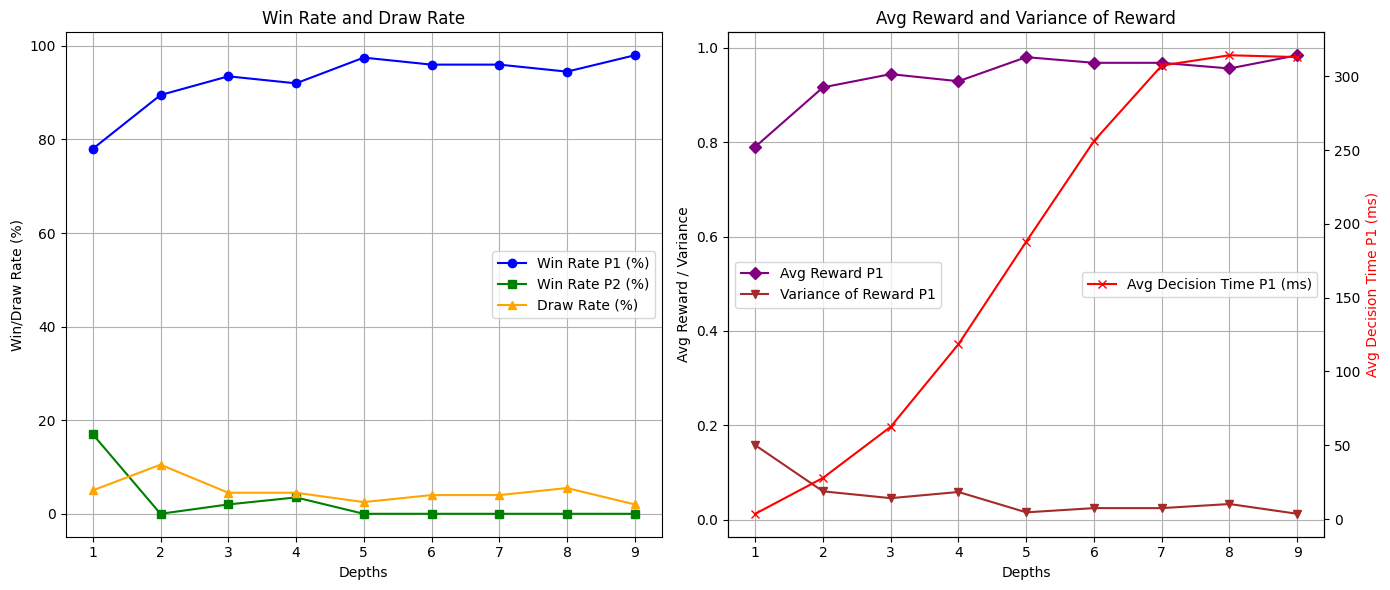

In [36]:
if 1==1 :
  # Run experiments with different parameters
  results = []

  random_player_1 = RandomPlayer(name="random1")


  # Case 2: Minimax with Alpha-Beta Pruning and different depths
  depths = [1,2, 3, 4, 5, 6, 7,8,9]
  for depth in depths:
      minimax_player = MinimaxPlayer(name=f"minimax_pruning_depth_{depth}", use_alpha_beta=True, max_depth=depth, use_cache=False)
      ttt = TicTacToe(minimax_player, random_player_1)
      result = ttt.evaluate(episodes=200)
      results.append(result)

  results = pd.DataFrame(results)


  print("Comparison of MinimaxPlayer with Different Depths")
  print(results)
  plot_tictactoe_results(results,"Depths")

### 5.2.2 Parameter alpha_beta_pruning change Analysis

In [37]:
if 1==1 :
  # Run experiments with different parameters
  results = []

  # Case 1: Minimax without Alpha-Beta Pruning
  minimax_player = MinimaxPlayer(name="minimax_no_pruning", use_alpha_beta=False, use_cache=False)
  ttt = TicTacToe(minimax_player, random_player_1)
  results_minimax_no_pruning = ttt.evaluate(episodes=100)
  results.append({
      'Depth': 'No Pruning',  # Make sure this is a string
      'Win Rate P1 (%)': results_minimax_no_pruning['Win Rate P1 (%)'],
      'Win Rate P2 (%)': results_minimax_no_pruning['Win Rate P2 (%)'],
      'Draw Rate (%)': results_minimax_no_pruning['Draw Rate (%)'],
      'Avg Reward P1': results_minimax_no_pruning['Avg Reward P1'],
      'Avg Moves': results_minimax_no_pruning['Avg Moves'],
      'Avg Decision Time P1 (ms)': results_minimax_no_pruning['Avg Decision Time P1 (ms)'],
      'Variance of Reward P1': results_minimax_no_pruning['Variance of Reward P1']
  })

  # Case 2: Minimax with Alpha-Beta Pruning and different depths
  depths = [1,2, 3, 4, 5, 6, 7,8,9]
  for depth in depths:
      minimax_player = MinimaxPlayer(name=f"minimax_pruning_depth{depth}", use_alpha_beta=True, max_depth=depth, use_cache=False)
      ttt = TicTacToe(minimax_player, random_player_1)
      results_minimax_vs_random = ttt.evaluate(episodes=100)
      results.append({
          'Depth': str(depth),  # Convert depth to string
          'Win Rate P1 (%)': results_minimax_vs_random['Win Rate P1 (%)'],
          'Win Rate P2 (%)': results_minimax_vs_random['Win Rate P2 (%)'],
          'Draw Rate (%)': results_minimax_vs_random['Draw Rate (%)'],
          'Avg Reward P1': results_minimax_vs_random['Avg Reward P1'],
          'Avg Moves': results_minimax_vs_random['Avg Moves'],
          'Avg Decision Time P1 (ms)': results_minimax_vs_random['Avg Decision Time P1 (ms)'],
          'Variance of Reward P1': results_minimax_vs_random['Variance of Reward P1']
      })


Comparison of MinimaxPlayer with and without Alpha-Beta Pruning (different depths):
        Depth  Win Rate P1 (%)  Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  \
0  No Pruning             95.0              0.0            5.0          0.960   
1           1             76.0             17.0            7.0          0.774   
2           2             88.0              1.0           11.0          0.902   
3           3             94.0              0.0            6.0          0.952   
4           4             94.0              1.0            5.0          0.950   
5           5             96.0              0.0            4.0          0.968   
6           6             97.0              0.0            3.0          0.976   
7           7             97.0              0.0            3.0          0.976   
8           8             95.0              0.0            5.0          0.960   
9           9             96.0              0.0            4.0          0.968   

   Avg Moves  Avg Decisi

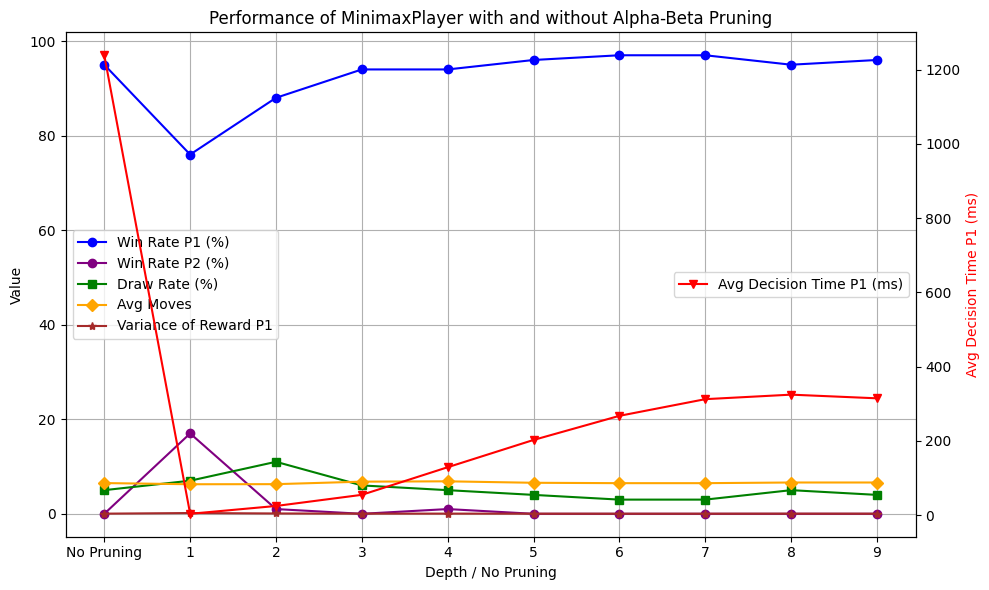

In [38]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results)
print("Comparison of MinimaxPlayer with and without Alpha-Beta Pruning (different depths):")
print(df_results)

# Create a figure and the left axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot on the left y-axis (Win Rate, Draw Rate, Avg Reward, Avg Moves, Variance of Reward)
ax1.plot(df_results['Depth'], df_results['Win Rate P1 (%)'], marker='o', label='Win Rate P1 (%)', color='blue')
ax1.plot(df_results['Depth'], df_results['Win Rate P2 (%)'], marker='o', label='Win Rate P2 (%)', color='purple')
ax1.plot(df_results['Depth'], df_results['Draw Rate (%)'], marker='s', label='Draw Rate (%)', color='green')
ax1.plot(df_results['Depth'], df_results['Avg Moves'], marker='D', label='Avg Moves', color='orange')
ax1.plot(df_results['Depth'], df_results['Variance of Reward P1'], marker='*', label='Variance of Reward P1', color='brown')

# Set the left y-axis labels and grid
ax1.set_xlabel('Depth / No Pruning')
ax1.set_ylabel('Value')
ax1.grid(True)
ax1.legend(loc='center left')

# Create the right y-axis for Avg Decision Time P1
ax2 = ax1.twinx()
ax2.plot(df_results['Depth'], df_results['Avg Decision Time P1 (ms)'], marker='v', label='Avg Decision Time P1 (ms)', color='red')

# Set the right y-axis label and legend
ax2.set_ylabel('Avg Decision Time P1 (ms)', color='red')
ax2.legend(loc='center right')

# Add a title and adjust layout
plt.title('Performance of MinimaxPlayer with and without Alpha-Beta Pruning')
plt.tight_layout()

# Show the plot
plt.show()


play order

In [39]:
results = []

minimax_player_1 = MinimaxPlayer(name="minimax_player1")
minimax_player_2 = MinimaxPlayer(name="minimax_player2")

ttt = TicTacToe(minimax_player_1, random_player_1)
eval_result = ttt.evaluate(episodes=200)
results.append({
    'Game Group': 'Minimax VS Random',  # Make sure this is a string
    'Win Rate P1 (%)': eval_result['Win Rate P1 (%)'],
    'Win Rate P2 (%)': eval_result['Win Rate P2 (%)'],
    'Draw Rate (%)': eval_result['Draw Rate (%)']
})

ttt = TicTacToe(random_player_1,minimax_player_1 )
eval_result = ttt.evaluate(episodes=200)
results.append({
    'Game Group': 'Random VS Minimax',  # Make sure this is a string
    'Win Rate P1 (%)': eval_result['Win Rate P1 (%)'],
    'Win Rate P2 (%)': eval_result['Win Rate P2 (%)'],
    'Draw Rate (%)': eval_result['Draw Rate (%)']
})


ttt = TicTacToe(minimax_player_2,minimax_player_1 )
eval_result = ttt.evaluate(episodes=200)
results.append({
    'Game Group': 'Minimax VS Minimax',  # Make sure this is a string
    'Win Rate P1 (%)': eval_result['Win Rate P1 (%)'],
    'Win Rate P2 (%)': eval_result['Win Rate P2 (%)'],
    'Draw Rate (%)': eval_result['Draw Rate (%)']
})

df_results = pd.DataFrame(results)
print("Evaluation Results of Tic-Tac-Toe Matches Highlighting the Importance of First Move (Minimax vs Random)")
print(df_results)


Evaluation Results of Tic-Tac-Toe Matches Highlighting the Importance of First Move (Minimax vs Random)
           Game Group  Win Rate P1 (%)  Win Rate P2 (%)  Draw Rate (%)
0   Minimax VS Random             97.0              0.0            3.0
1   Random VS Minimax              0.0             80.5           19.5
2  Minimax VS Minimax              0.0              0.0          100.0


# **Step 7. MCTS Algorithm**

## 7.1 Algorithm Description

explain something

In [9]:
# Algorithm Implement



# Monte Carlo Tree Search (MCTS) Player
class MCTSPlayer:
    def __init__(self, player_num, simulations=100):
        self.player_num = player_num
        self.opponent_num = 1 if player_num == 2 else 2
        self.simulations = simulations

    def rollout(self, game):
        current_player = self.player_num
        while True:
            if game.is_winner(self.player_num):
                return 1
            if game.is_winner(self.opponent_num):
                return -1
            if game.is_draw():
                return 0
            row, col = random.choice(game.get_empty_positions())
            game.make_move(row, col, current_player)
            current_player = 1 if current_player == 2 else 2

    def move(self, game):
        best_move = None
        best_score = -float('inf')

        for row, col in game.get_empty_positions():
            score = 0
            for _ in range(self.simulations):
                game_copy = TicTacToe()
                game_copy.board = game.board.copy()
                game_copy.make_move(row, col, self.player_num)
                score += self.rollout(game_copy)
            if score > best_score:
                best_score = score
                best_move = (row, col)
        return best_move




## 7.2 Parameters Analysis

### 7.2.1 Parameter1 change Analysis

**Show Plt**

## 7.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 8. Q-learning Algorithm**

## 8.1 Algorithm Description

explain something

* α（学习率）：0.1 到 0.3。选择较低的学习率，以防止 Q 值更新过度调整。
* ε（探索率）：开始时为 0.9（高探索率），随着时间逐渐衰减到 0.1 或更低。
* γ（折扣因子）：0.9 到 0.95。强调长期回报，关注赢得游戏的未来奖励。

In [42]:
class QLearningPlayer:
    def __init__(self, name='q-agent', alpha=0.6, epsilon=0.3, gamma=0.95):
        # Initialize the QLearningPlayer with learning rate (alpha), exploration rate (epsilon), and discount factor (gamma)
        self.name = name
        self.states = []
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        self.gamma = gamma  # Discount factor
        self.Q_table = {}  # Dictionary to store Q-values
        self.q_value_changes = []  # List to store Q-value changes for monitoring

    def getHash(self, board):
        # Generate a unique hash for the current board state (used for state-action mapping)
        return str(board.board.flatten())

    def getMove(self, positions, current_board):
        # Decide between exploration (random move) and exploitation (best known move)
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration: Choose a random move
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            # Exploitation: Choose the best move based on Q-values
            action = self._choose_best_action(positions, current_board)
        return action

    def _choose_best_action(self, positions, current_board):
        # Choose the action that has the highest Q-value for the current state
        maxValue = -999
        for p in positions:
            nextBoard = current_board.copy()
            nextBoard.push(tuple(p))
            nextBoardState = self.getHash(nextBoard)
            value = self.Q_table.get(nextBoardState, 0)  # Use a default value of 0 if the state is not in Q-table
            if value > maxValue:
                maxValue = value
                action = p
        return action

    def setState(self, state):
        # Store the current state (for future Q-value updates)
        self.states.append(state)

    def setReward(self, reward):
        # Update Q-values based on rewards received
        for st in reversed(self.states):
            if st not in self.Q_table:
                self.Q_table[st] = 0
            prev_value = self.Q_table[st]
            # Q-learning update rule: Q(s, a) = Q(s, a) + alpha * (reward + gamma * max(Q(s', a')) - Q(s, a))
            self.Q_table[st] += self.alpha * (self.gamma * reward - self.Q_table[st])

            # Store Q-value change for monitoring
            q_value_delta = abs(self.Q_table[st] - prev_value)
            self.q_value_changes.append(q_value_delta)

            # Pass the updated Q-value as the reward for the next state
            reward = self.Q_table[st]

    def getQValueChanges(self):
        # Return the list of Q-value changes for analysis or monitoring
        return self.q_value_changes

    def resetQValueChanges(self):
        # Reset the list of Q-value changes
        self.q_value_changes = []

    def reset(self):
        # Reset the state history for a new game
        self.states = []

    def savePolicy(self):
        # Save the Q-table (policy) to a file
        filename = 'policy_' + str(self.name)
        print('Saving Policy: ' + str(filename))
        with open(filename, 'wb') as fw:
            pickle.dump(self.Q_table, fw)

    def loadPolicy(self, file):
        # Load a Q-table (policy) from a file
        with open(file, 'rb') as fr:
            self.Q_table = pickle.load(fr)

In [54]:
# Core function to run Q-learning experiment and collect data
def run_qlearning_experiment(alpha, gamma, epsilon, train_episode,trainingWithMinimax=False, q_agent_name="q-agent"):
    """
    Runs a Q-learning experiment with specified parameters and returns performance metrics.

    Parameters:
    - alpha: Learning rate for Q-learning.
    - gamma: Discount factor for future rewards in Q-learning.
    - epsilon: Exploration rate, controls the exploration-exploitation tradeoff.
    - train_episode: Number of training episodes to run.

    Returns:
    - A dictionary containing the results of the experiment, including win rates, average reward, and training time.
    """

    # Initialize Q-learning player and the TicTacToe game
    q_learning_player = QLearningPlayer(q_agent_name, alpha, epsilon, gamma)

    if trainingWithMinimax:
        opponent = MinimaxPlayer(name=f"minimax_pruning_depth9")
    else:
        opponent = RandomPlayer(name="random1")

    game = TicTacToe(q_learning_player, opponent)

    # Measure the time taken to train the Q-learning model
    start_time = time.time()
    game.train(episodes=train_episode)
    train_time = time.time() - start_time

    # Save the learned Q-table (policy)
    q_learning_player.savePolicy()

    # Load the trained policy for evaluation
    p1 = QLearningPlayer('p1', epsilon=0)  # epsilon=0 to ensure full exploitation, no exploration
    p1.loadPolicy('policy_'+q_agent_name)

    # Evaluate the Q-learning player against a random player
    ttt = TicTacToe(q_learning_player, opponent)
    results_qlearning_vs_random = ttt.evaluate(episodes=100)

    # Return results as a dictionary
    return {
        'alpha': alpha,
        'gamma': gamma,
        'epsilon': epsilon,
        'train_episode': train_episode,
        'Train Time (s)': train_time,
        'Win Rate P1 (%)': results_qlearning_vs_random['Win Rate P1 (%)'],
        'Win Rate P2 (%)': results_qlearning_vs_random['Win Rate P2 (%)'],
        'Draw Rate (%)': results_qlearning_vs_random['Draw Rate (%)'],
        'Avg Reward P1': results_qlearning_vs_random['Avg Reward P1'],
        'Avg Moves': results_qlearning_vs_random['Avg Moves'],
        'Avg Decision Time P1 (ms)': results_qlearning_vs_random['Avg Decision Time P1 (ms)'],
        'Variance of Reward P1': results_qlearning_vs_random['Variance of Reward P1']
    }


# Function to plot results with two separate charts
def plot_results(df_results, param_name):
    """
    Plots the performance metrics of the Q-learning experiment in two side-by-side charts.

    Parameters:
    - df_results: DataFrame containing experiment results.
    - param_name: Name of the parameter to plot against (e.g., 'train_episode').
    """

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # First plot: Plot Win Rate, Draw Rate
    ax1.plot(df_results[param_name], df_results['Win Rate P1 (%)'], marker='o', color='blue', label='Win Rate P1 (%)')
    ax1.plot(df_results[param_name], df_results['Win Rate P2 (%)'], marker='s', color='green', label='Win Rate P2 (%)')
    ax1.plot(df_results[param_name], df_results['Draw Rate (%)'], marker='^', color='orange', label='Draw Rate (%)')

    # Add legends, labels, and grid to the first chart
    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Win/Draw Rate (%)')
    ax1.legend(loc='center right')
    ax1.grid(True)
    ax1.set_title('Win Rate and Draw Rate')

    # Second plot: Plot Avg Reward, Variance of Reward
    ax2.plot(df_results[param_name], df_results['Avg Reward P1'], marker='D', color='purple', label='Avg Reward P1')
    ax2.plot(df_results[param_name], df_results['Variance of Reward P1'], marker='v', color='brown', label='Variance of Reward P1')

    # Add legends, labels, and grid to the second chart
    ax2.set_xlabel(param_name)
    ax2.set_ylabel('Avg Reward / Variance')
    ax2.legend(loc='center left')
    ax2.grid(True)
    ax2.set_title('Avg Reward and Variance of Reward')

    # Create a right y-axis on the second chart for Train Time
    ax3 = ax2.twinx()  # Create a shared x-axis for the second y-axis
    ax3.plot(df_results[param_name], df_results['Train Time (s)'], marker='x', color='red', label='Train Time (s)')
    ax3.set_ylabel('Train Time (s)', color='red')
    ax3.legend(loc='center right')

    # Adjust layout and show the charts
    plt.tight_layout()
    plt.show()

# Function to plot the results in a single chart
def plot_results_v0(df_results, param_name):
    """
    Plots the performance metrics of the Q-learning experiment on a single chart.

    Parameters:
    - df_results: DataFrame containing experiment results.
    - param_name: Name of the parameter to plot against (e.g., 'train_episode').
    """

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Win Rate, Draw Rate, Avg Reward, Avg Moves, Avg Decision Time, Variance of Reward on the left axis
    ax1.plot(df_results[param_name], df_results['Win Rate P1 (%)'], marker='o', label='Win Rate P1 (%)')
    ax1.plot(df_results[param_name], df_results['Win Rate P2 (%)'], marker='o', label='Win Rate P2 (%)')
    ax1.plot(df_results[param_name], df_results['Draw Rate (%)'], marker='o', label='Draw Rate (%)')
    ax1.plot(df_results[param_name], df_results['Avg Reward P1'], marker='o', label='Avg Reward P1')
    ax1.plot(df_results[param_name], df_results['Avg Moves'], marker='o', label='Avg Moves')
    ax1.plot(df_results[param_name], df_results['Avg Decision Time P1 (ms)'], marker='o', label='Avg Decision Time P1 (ms)')
    ax1.plot(df_results[param_name], df_results['Variance of Reward P1'], marker='o', label='Variance of Reward P1')

    # Add legends, labels, and grid to the left axis
    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Performance Metrics')
    ax1.legend(loc='center right')
    ax1.grid(True)

    # Plot Training Time on the right axis
    ax2 = ax1.twinx()  # Create a shared x-axis for the second y-axis
    ax2.plot(df_results[param_name], df_results['Train Time (s)'], marker='x', color='red', label='Train Time (s)')
    ax2.set_ylabel('Train Time (s)', color='red')
    ax2.legend(loc='upper right')

    # Show the chart
    plt.title(f'Performance of QLearningPlayer with varying {param_name}')
    plt.tight_layout()
    plt.show()


## 8.2 Parameters Analysis

### 8.2.1 train_episodes change Analysis

    alpha  gamma  epsilon  train_episode  Train Time (s)  Win Rate P1 (%)  \
0     0.2    0.9      0.3              1        0.041545             69.0   
1     0.2    0.9      0.3             10        0.116363             66.0   
2     0.2    0.9      0.3             20        0.189872             70.0   
3     0.2    0.9      0.3             50        0.380583             62.0   
4     0.2    0.9      0.3            100        0.578586             63.0   
5     0.2    0.9      0.3            500        2.027613             71.0   
6     0.2    0.9      0.3           1000        5.001501             71.0   
7     0.2    0.9      0.3           2000        7.967290             83.0   
8     0.2    0.9      0.3           5000       17.179230             84.0   
9     0.2    0.9      0.3          10000       30.916796             87.0   
10    0.2    0.9      0.3          20000       61.342903             90.0   

    Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  Avg Moves  \
0          

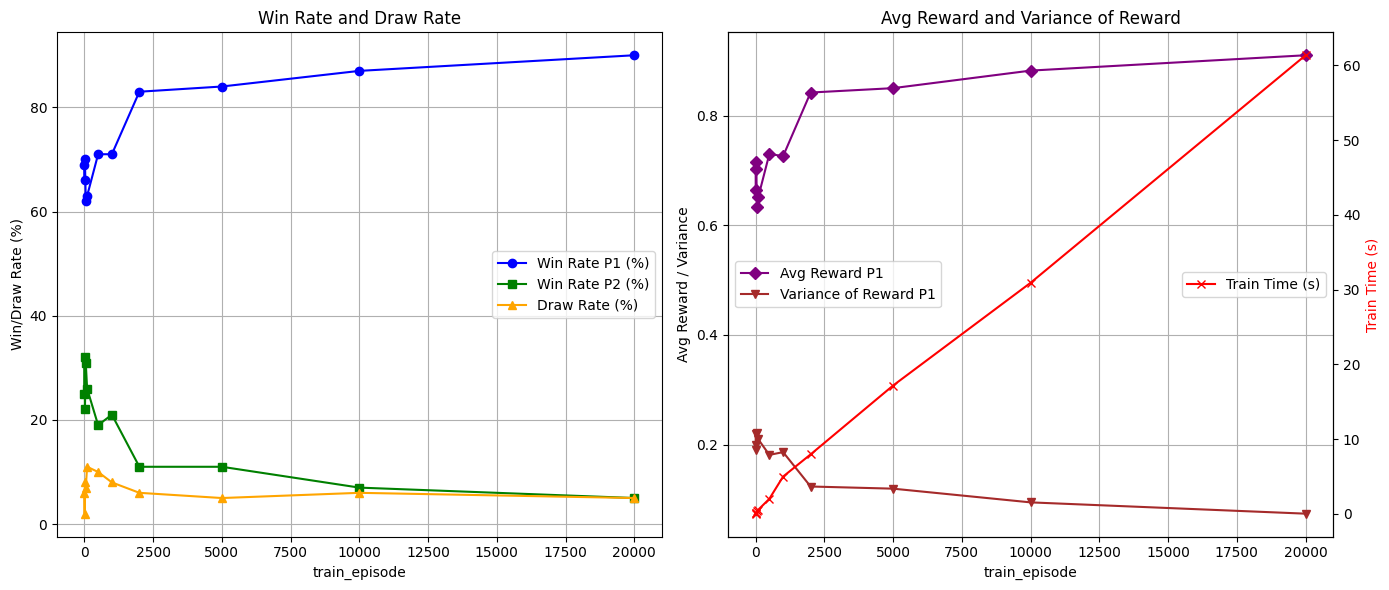

In [44]:

# Parameter settings for the experiment
train_episodes = [1,10,20,50,100,500,1000, 2000,5000,10000, 20000]#, 30000,50000,100000]  # Training episodes

# Compare the performance with different numbers of training episodes
results_train_episodes = []
for train_episode in train_episodes:
    results_train_episodes.append(run_qlearning_experiment(alpha=0.2, gamma=0.9, epsilon=0.3, train_episode=train_episode))

# Convert the results into a DataFrame for easy visualization
df_train_episodes = pd.DataFrame(results_train_episodes)
print(df_train_episodes)

# Plot the results based on the number of training episodes
plot_results(df_train_episodes, 'train_episode')

### 8.2.2 Q value change Analysis

100%|██████████| 20000/20000 [01:04<00:00, 311.77it/s]


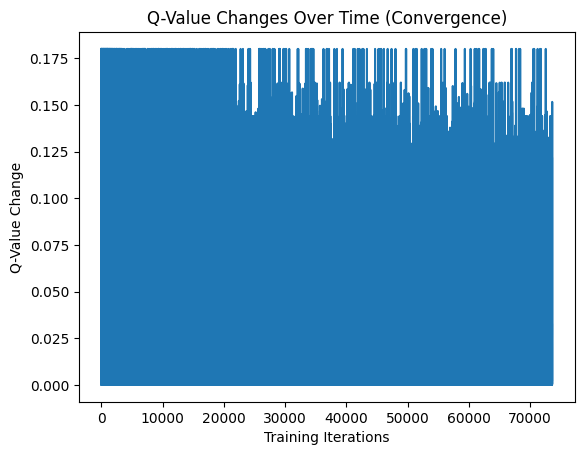

In [45]:
# Setting Q-learning parameters
train_episode = 20000  # Number of training episodes
alpha = 0.2  # Learning rate for Q-learning
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.3  # Exploration rate to control exploration vs exploitation

# Initialize the Q-learning player and the game
q_learning_player = QLearningPlayer('q-agent', alpha, epsilon, gamma)

# You can choose to use a random player as the opponent
# random_player_1 = RandomPlayer(name="random1")

# Assume you want to observe Q-value changes after 1000 training episodes
q_learning_player.resetQValueChanges()  # Reset the Q-value change records to start fresh

# Initialize the TicTacToe game with the Q-learning player vs a random player
game = TicTacToe(q_learning_player, random_player_1)

# Train the Q-learning player for the defined number of episodes
game.train(episodes=train_episode)

# Retrieve the recorded Q-value changes during training
q_value_changes = q_learning_player.getQValueChanges()

# Plot the trend of Q-value changes over time to observe convergence
plt.plot(q_value_changes)
plt.xlabel('Training Iterations')  # X-axis: number of iterations during training
plt.ylabel('Q-Value Change')  # Y-axis: amount of change in Q-values
plt.title('Q-Value Changes Over Time (Convergence)')  # Title of the graph
plt.show()


### 8.2.3 Learning Rate change Analysis

   alpha  gamma  epsilon  train_episode  Train Time (s)  Win Rate P1 (%)  \
0   0.02    0.9      0.3          20000       62.021546             88.0   
1   0.05    0.9      0.3          20000       64.602521             86.0   
2   0.10    0.9      0.3          20000       61.657079             78.0   
3   0.15    0.9      0.3          20000       62.305780             88.0   
4   0.20    0.9      0.3          20000       62.649753             81.0   
5   0.32    0.9      0.3          20000       62.126077             83.0   
6   0.64    0.9      0.3          20000       63.354017             80.0   
7   0.80    0.9      0.3          20000       66.712718             86.0   

   Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  Avg Moves  \
0              7.0            5.0          0.890       6.21   
1             13.0            1.0          0.862       6.53   
2             17.0            5.0          0.790       6.33   
3              9.0            3.0          0.886       6.07   


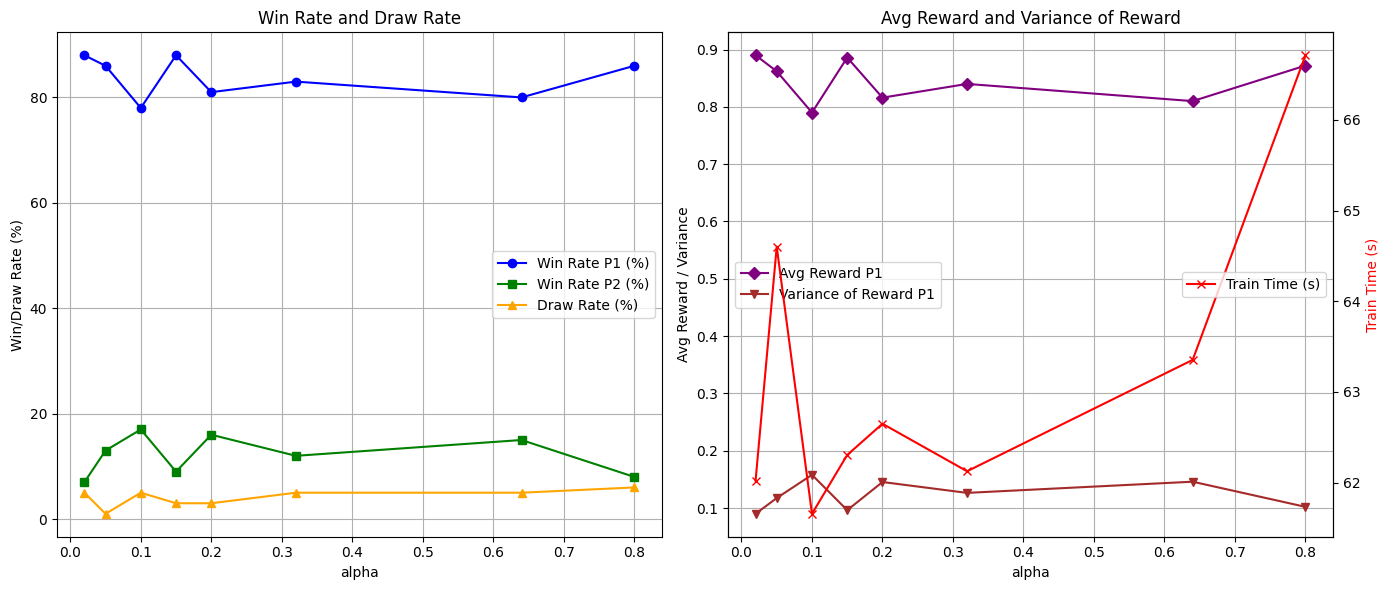

In [46]:
# Setting parameters for Q-learning
train_episode = 20000  # Number of training episodes
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.3  # Exploration rate to control exploration vs exploitation

# List of different alphas (learning rates) to test
alphas = [0.02, 0.05, 0.1, 0.15, 0.2, 0.32, 0.64, 0.8]  # Learning rates to test 0.02

# List to store results for different alphas
results_alphas = []

# Iterate through each alpha (learning rate) and run the experiment
for alpha in alphas:
    results_alphas.append(run_qlearning_experiment(alpha=alpha, gamma=gamma, epsilon=epsilon, train_episode=train_episode))

# Convert the results for each alpha into a DataFrame for easy manipulation and visualization
df_alphas = pd.DataFrame(results_alphas)
print(df_alphas)

# Plot the results of testing different alphas
plot_results(df_alphas, 'alpha')


### 8.2.4 gamma change Analysis

   alpha  gamma  epsilon  train_episode  Train Time (s)  Win Rate P1 (%)  \
0   0.02   0.20      0.3          20000       63.783219             87.0   
1   0.02   0.40      0.3          20000       61.746208             79.0   
2   0.02   0.60      0.3          20000       62.841605             84.0   
3   0.02   0.80      0.3          20000       61.011967             89.0   
4   0.02   0.90      0.3          20000       60.634555             90.0   
5   0.02   0.95      0.3          20000       63.399663             82.0   
6   0.02   0.99      0.3          20000       60.717332             90.0   

   Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  Avg Moves  \
0             11.0            2.0          0.874       6.23   
1             17.0            4.0          0.798       6.09   
2             15.0            1.0          0.842       6.05   
3              5.0            6.0          0.902       6.17   
4              5.0            5.0          0.910       6.19   
5            

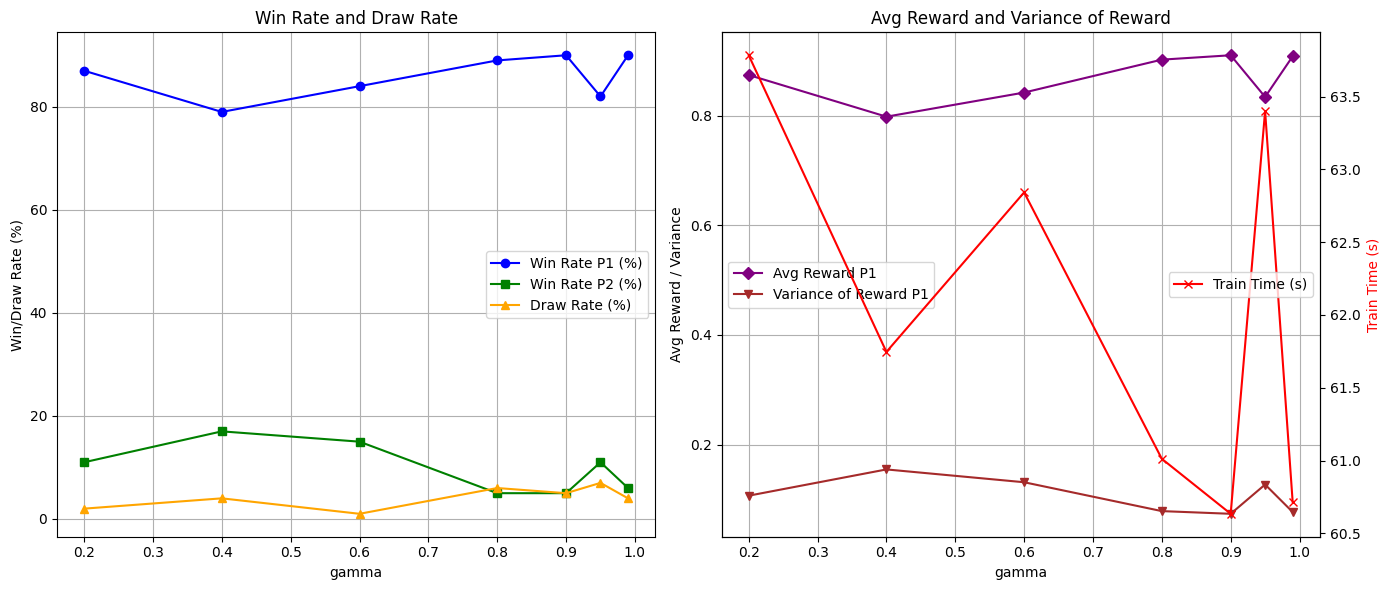

In [49]:
# Setting parameters for Q-learning
train_episode = 20000  # Number of training episodes
alpha = 0.02  # Learning rate for Q-learning
epsilon = 0.3  # Exploration rate to control exploration vs exploitation

# List of different gammas (discount factors) to test
gammas = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95,0.99]  # Discount factors to test 0.9

# List to store results for different gammas
results_gammas = []

# Iterate through each gamma (discount factor) and run the experiment
for gamma in gammas:
    results_gammas.append(run_qlearning_experiment(alpha=alpha, gamma=gamma, epsilon=epsilon, train_episode=train_episode))

# Convert the results for each gamma into a DataFrame for easy manipulation and visualization
df_gammas = pd.DataFrame(results_gammas)
print(df_gammas)

# Plot the results of testing different gammas
plot_results(df_gammas, 'gamma')


### 8.2.5 epsilon change Analysis

   alpha  gamma  epsilon  train_episode  Train Time (s)  Win Rate P1 (%)  \
0    0.2    0.9     0.02          20000       69.609444             91.0   
1    0.2    0.9     0.05          20000       66.596618             91.0   
2    0.2    0.9     0.10          20000       67.590398             93.0   
3    0.2    0.9     0.20          20000       64.532169             88.0   
4    0.2    0.9     0.30          20000       62.460715             86.0   

   Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  Avg Moves  \
0              2.0            7.0          0.924       6.16   
1              6.0            3.0          0.916       5.96   
2              3.0            4.0          0.938       5.89   
3              9.0            3.0          0.886       6.07   
4             12.0            2.0          0.864       6.30   

   Avg Decision Time P1 (ms)  Variance of Reward P1  
0                   3.932860               0.059024  
1                   3.550203               0.072144  
2 

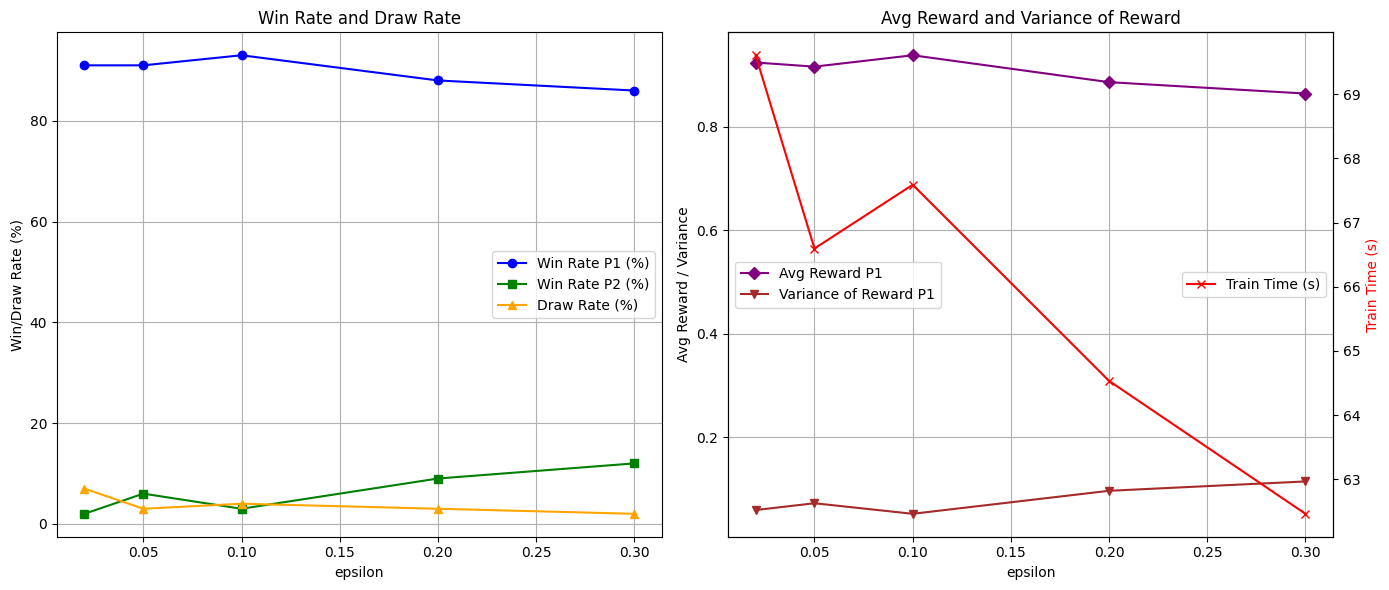

In [51]:
# Setting parameters for Q-learning
train_episode = 20000  # Number of training episodes
alpha = 0.2  # Learning rate for Q-learning
gamma = 0.9  # Discount factor for future rewards

# List of different exploration rates (epsilons) to test
epsilons = [0.02,0.05,0.1, 0.2, 0.3]  # Exploration rates to test ##0.1

# List to store results for different epsilons
results_epsilons = []

# Iterate through each epsilon (exploration rate) and run the experiment
for epsilon in epsilons:
    results_epsilons.append(run_qlearning_experiment(alpha=alpha, gamma=gamma, epsilon=epsilon, train_episode=train_episode))

# Convert the results for each epsilon into a DataFrame for easy manipulation and visualization
df_epsilons = pd.DataFrame(results_epsilons)
print(df_epsilons)

# Plot the results of testing different epsilons
plot_results(df_epsilons, 'epsilon')


### 8.2.6 Different Opponent in Training Analysis

   alpha  gamma  epsilon  train_episode  Train Time (s)  Win Rate P1 (%)  \
0    0.2    0.9      0.1         200000      650.130568             97.0   

   Win Rate P2 (%)  Draw Rate (%)  Avg Reward P1  Avg Moves  \
0              0.0            3.0          0.976       5.36   

   Avg Decision Time P1 (ms)  Variance of Reward P1  
0                   3.157933               0.018624  


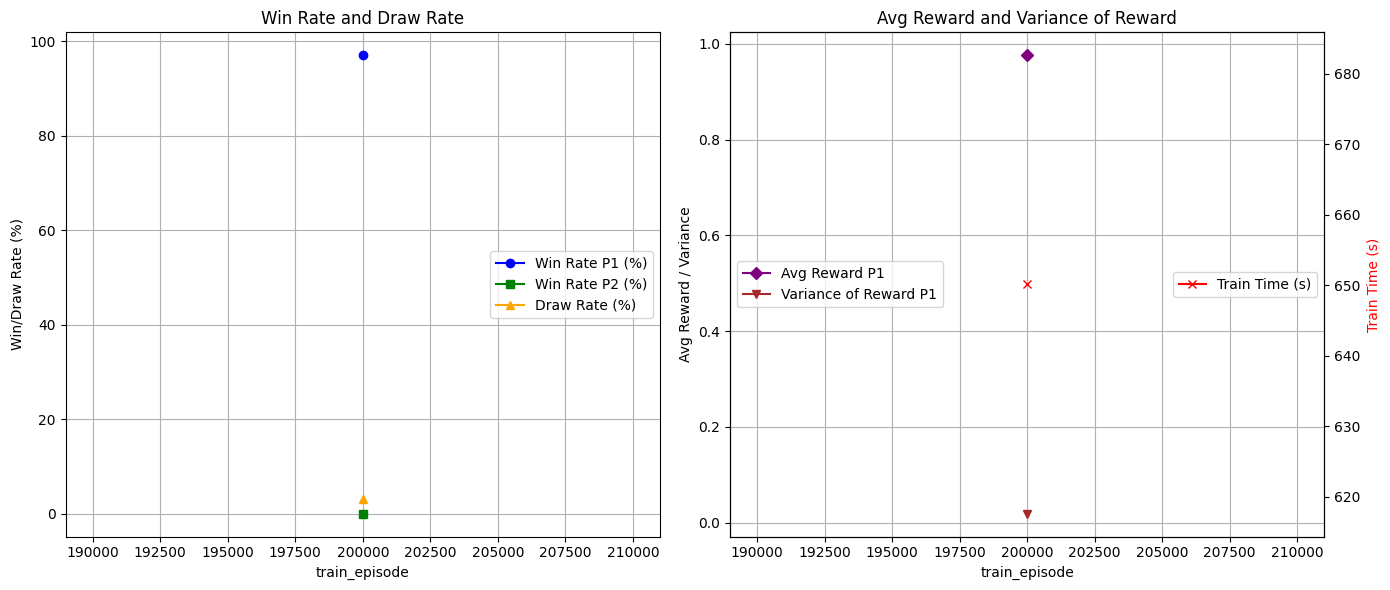

In [67]:
train_episode = 200000  # Number of training episodes
alpha = 0.2  # Learning rate for Q-learning
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.1 #exploration rates (epsilons)


# Compare the performance with different numbers of training episodes
results_train_episodes = []


results_train_episodes.append(run_qlearning_experiment(alpha=alpha, gamma=gamma, epsilon=epsilon, train_episode=train_episode,trainingWithMinimax=True, q_agent_name="q-agent-minimax"))

# Convert the results into a DataFrame for easy visualization
df_train_episodes = pd.DataFrame(results_train_episodes)
print(df_train_episodes)

# Plot the results based on the number of training episodes
plot_results(df_train_episodes, 'train_episode')

In [68]:

q_agent_name = "q-agent-minimax"
# Load the trained policy for evaluation
p1 = QLearningPlayer('p1', epsilon=0)  # epsilon=0 to ensure full exploitation, no exploration
p1.loadPolicy('policy_' + q_agent_name)

p2 = QLearningPlayer('p1', epsilon=0)  # epsilon=0 to ensure full exploitation, no exploration
p2.loadPolicy('policy_' + q_agent_name)

# Initialize the opponent players
random_opponent = RandomPlayer(name="random1")
minimax_opponent = MinimaxPlayer(name="minimax_pruning_depth9")

# Evaluate the Q-learning player against the Random player
ttt = TicTacToe(q_learning_player, random_opponent)
result_random = ttt.evaluate(episodes=100)

# Evaluate the Q-learning player against the Minimax player
ttt = TicTacToe(q_learning_player, minimax_opponent)
result_minimax = ttt.evaluate(episodes=100)

# Evaluate the Q-learning player against another Q-learning player
ttt = TicTacToe(q_learning_player, p2)
result_qlearning = ttt.evaluate(episodes=100)

# Combine the results into a single DataFrame
results = {
    "Opponent": ["RandomPlayer", "MinimaxPlayer", "QLearningPlayer"],
    "Win Rate P1 (%)": [result_random['Win Rate P1 (%)'], result_minimax['Win Rate P1 (%)'], result_qlearning['Win Rate P1 (%)']],
    "Win Rate P2 (%)": [result_random['Win Rate P2 (%)'], result_minimax['Win Rate P2 (%)'], result_qlearning['Win Rate P2 (%)']],
    "Draw Rate (%)": [result_random['Draw Rate (%)'], result_minimax['Draw Rate (%)'], result_qlearning['Draw Rate (%)']],
    "Avg Reward P1": [result_random['Avg Reward P1'], result_minimax['Avg Reward P1'], result_qlearning['Avg Reward P1']],
    "Avg Reward P2": [result_random['Avg Reward P2'], result_minimax['Avg Reward P2'], result_qlearning['Avg Reward P2']],
    "Reward P1": [result_random['Reward P1'], result_minimax['Reward P1'], result_qlearning['Reward P1']],
    "Reward P2": [result_random['Reward P2'], result_minimax['Reward P2'], result_qlearning['Reward P2']],
    "Avg Moves": [result_random['Avg Moves'], result_minimax['Avg Moves'], result_qlearning['Avg Moves']],
    "Avg Decision Time P1 (ms)": [result_random['Avg Decision Time P1 (ms)'], result_minimax['Avg Decision Time P1 (ms)'], result_qlearning['Avg Decision Time P1 (ms)']],
    "Avg Decision Time P2 (ms)": [result_random['Avg Decision Time P2 (ms)'], result_minimax['Avg Decision Time P2 (ms)'], result_qlearning['Avg Decision Time P2 (ms)']],
    "Variance of Reward P1": [result_random['Variance of Reward P1'], result_minimax['Variance of Reward P1'], result_qlearning['Variance of Reward P1']],
    "Variance of Reward P2": [result_random['Variance of Reward P2'], result_minimax['Variance of Reward P2'], result_qlearning['Variance of Reward P2']]
}

df = pd.DataFrame(results)
print(df)

In [69]:
print(df)

          Opponent  Win Rate P1 (%)  Win Rate P2 (%)  Draw Rate (%)  \
0     RandomPlayer             82.0             11.0            7.0   
1    MinimaxPlayer             15.0             26.0           59.0   
2  QLearningPlayer             91.0              7.0            2.0   

   Avg Reward P1  Avg Reward P2  Reward P1  Reward P2  Avg Moves  \
0          0.834          0.124       83.4       12.4       6.43   
1          0.268          0.378       26.8       37.8       8.36   
2          0.914          0.074       91.4        7.4       6.03   

   Avg Decision Time P1 (ms)  Avg Decision Time P2 (ms)  \
0                   3.029318                   0.258296   
1                   3.299994                 122.606287   
2                   3.016553                   3.043864   

   Variance of Reward P1  Variance of Reward P2  
0               0.127244               0.097424  
1               0.101776               0.140716  
2               0.075404               0.065324  


# **Step 9. DQN Algorithm**

## 9.1 Algorithm Description

explain something

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Tic-Tac-Toe board class
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)

    def reset(self):
        self.board.fill(0)

    def make_move(self, row, col, player):
        if self.board[row, col] == 0:
            self.board[row, col] = player
            return True
        return False

    def is_winner(self, player):
        for row in range(3):
            if np.all(self.board[row, :] == player):
                return True
        for col in range(3):
            if np.all(self.board[:, col] == player):
                return True
        if self.board[0, 0] == player and self.board[1, 1] == player and self.board[2, 2] == player:
            return True
        if self.board[0, 2] == player and self.board[1, 1] == player and self.board[2, 0] == player:
            return True
        return False

    def is_draw(self):
        return np.all(self.board != 0)

    def get_empty_positions(self):
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]

    def print_board(self):
        print(self.board)

# Define the DQN neural network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 9)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Output is Q-values for each action

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Deep Q-Network (DQN) Player
class DQNPlayer:
    def __init__(self, player_num, epsilon=0.1, gamma=0.9, batch_size=32, memory_capacity=1000, learning_rate=0.001):
        self.player_num = player_num
        self.opponent_num = 1 if player_num == 2 else 2
        self.model = DQN()
        self.target_model = DQN()
        self.target_model.load_state_dict(self.model.state_dict())  # Initialize target model with the same weights
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.memory = ReplayMemory(memory_capacity)
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.update_target_steps = 100  # Update the target model every 100 steps
        self.steps_done = 0

    def get_state(self, game):
        return torch.FloatTensor(game.board.reshape(9))

    def choose_action(self, game):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(game.get_empty_positions())  # Exploration
        else:
            state = self.get_state(game).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
            valid_moves = game.get_empty_positions()
            valid_q_values = [q_values[0, i * 3 + j].item() for i, j in valid_moves]
            max_q_value = max(valid_q_values)
            return valid_moves[valid_q_values.index(max_q_value)]  # Exploitation

    def store_memory(self, game, action, reward, next_game, done):
        state = self.get_state(game)
        next_state = self.get_state(next_game)
        self.memory.push(state, action, reward, next_state, done)

    def train_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        for state, action, reward, next_state, done in batch:
            q_values = self.model(state)
            q_target = q_values.clone().detach()
            next_q_values = self.target_model(next_state)
            max_next_q = torch.max(next_q_values).item()

            if done:
                target_value = reward
            else:
                target_value = reward + self.gamma * max_next_q

            q_target[0, action] = target_value
            self.optimizer.zero_grad()
            loss = self.loss_fn(q_values, q_target)
            loss.backward()
            self.optimizer.step()

        self.steps_done += 1
        if self.steps_done % self.update_target_steps == 0:
            self.target_model.load_state_dict(self.model.state_dict())  # Update target model

    def move(self, game):
        action = self.choose_action(game)
        return action

# Play a match
def play_game(player1, player2, game):
    game.reset()
    current_player = player1
    next_player = player2
    while True:
        row, col = current_player.move(game)
        game.make_move(row, col, current_player.player_num)
        if game.is_winner(current_player.player_num):
            return current_player.player_num
        if game.is_draw():
            return 0
        current_player, next_player = next_player, current_player

# Now rerun the main part to train the DQN player and plot the results
if __name__ == '__main__':
    game = TicTacToe()
    dqn_player = DQNPlayer(1)
    random_player = RandomPlayer(2)

    # Store results for plotting
    results = []

    # Simulate training over multiple games
    episodes = 5000  # Number of games to play
    for episode in range(episodes):
        result = play_game(dqn_player, random_player, game)
        results.append(result)  # Store the result for plotting
        dqn_player.train_model()

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, episodes + 1), results, label='Game Results')
    plt.xlabel('Episodes')
    plt.ylabel('Result (1 = DQN Wins, 0 = Draw, 2 = Random Wins)')
    plt.title('DQN vs Random Player Results Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

In [ ]:

# Define a function to evaluate the model (todo)

# List of parameter1 to test
parameter_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

#evaluate_model with different parameter

for lr in parameter_list:
    result = evaluate_model(lr)
    results.append((result))

# Convert results to a DataFrame for better visualization

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


**Show Plt**

In [ ]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 5.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 10. Discussion and Analysis**

## 10.1 Visual Performance comparision
Use graphs and tables to compare the performance of different algorithms. Show win rates, decision time, and convergence rate.

In [ ]:

# Minimax player and random player initialization
minimax_player = MinimaxPlayer(name="minimax", use_alpha_beta=True, max_depth=9)
minimax_player3 = MinimaxPlayer(name="minimax3", use_alpha_beta=True, max_depth=3)
minimax_player9 = MinimaxPlayer(name="minimax9", use_alpha_beta=True, max_depth=9)

random_player_1 = RandomPlayer(name="random1")

# Q-learning parameters
alpha = 0.02
gamma = 0.8
epsilon = 0.2
train_episode = 20000

# Initialize Q-learning player and train it
q_learning_player = QLearningPlayer('q-agent', alpha, epsilon, gamma)
game = TicTacToe(q_learning_player, random_player_1)
game.train(episodes=train_episode)

# Save Q-learning policy
q_learning_player.savePolicy()

# Load the trained Q-learning player for evaluation (fully exploit the learned policy)
p1 = QLearningPlayer('p1', epsilon=0)  # epsilon=0: no exploration, fully exploiting
p1.loadPolicy('policy_q-agent')

# Evaluate 1: MinimaxPlayer vs QLearningPlayer
ttt = TicTacToe(minimax_player, q_learning_player)
results_minimax_vs_qlearning = ttt.evaluate(episodes=100)

# Evaluate 2: MinimaxPlayer vs RandomPlayer
ttt = TicTacToe(minimax_player, random_player_1)
results_minimax_vs_random = ttt.evaluate(episodes=100)

# Evaluate 3: QLearningPlayer vs RandomPlayer
ttt = TicTacToe(q_learning_player, random_player_1)
results_qlearning_vs_random = ttt.evaluate(episodes=100)

# Evaluate 4: RandomPlayer vs RandomPlayer
ttt = TicTacToe(random_player_1, RandomPlayer(name="random2"))
results_random_vs_random = ttt.evaluate(episodes=100)

# Evaluate 5: minimax vs minimax2
ttt = TicTacToe(minimax_player, minimax_player3)
results_minimax_vs_minimax2 = ttt.evaluate(episodes=100)


ttt = TicTacToe(minimax_player, minimax_player3)
results_minimax_vs_minimax3 = ttt.evaluate(episodes=100)

ttt = TicTacToe(minimax_player, minimax_player9)
results_minimax_vs_minimax9= ttt.evaluate(episodes=100)

# Collect all results in a DataFrame
df_results = pd.DataFrame([
    results_minimax_vs_qlearning,
    results_minimax_vs_random,
    results_qlearning_vs_random,
    results_random_vs_random,
    results_minimax_vs_minimax3,
    results_minimax_vs_minimax9
])

df_results.columns = ['Win Rate P1 (%)', 'Win Rate P2 (%)', 'Draw Rate (%)',
                      'Avg Reward P1', 'Avg Reward P2','Reward P1', 'Reward P2', 'Avg Moves',
                      'Avg Decision Time P1 (ms)', 'Avg Decision Time P2 (ms)',
                      'Variance of Reward P1', 'Variance of Reward P2']


df_results.index = ['MinimaxPlayer vs QLearningPlayer',
                    'MinimaxPlayer vs RandomPlayer',
                    'QLearningPlayer vs RandomPlayer',
                    'RandomPlayer vs RandomPlayer',
                    'minimaxPlayer vs minimaxPlayer3',
                    'minimaxPlayer vs minimaxPlayer9']



df_results = df_results[['Win Rate P1 (%)', 'Win Rate P2 (%)', 'Draw Rate (%)']]

# Plotting the results with horizontal bars
ax = df_results.plot(kind='barh', figsize=(12, 8), color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Set title and labels
plt.title('Performance Comparison', fontsize=16)
plt.ylabel('Matchups', fontsize=12)
plt.xlabel('Metrics', fontsize=12)

# Move the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metrics")

# Add grid lines to make it easier to compare metrics
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust the layout to fit the legend and labels
plt.tight_layout()

# Show the plot
plt.show()


## 10.2 Compare the strengths and weaknesses of RL (e.g., Q-learning, DQN) vs. planning algorithms (Minimax, MCTS).

# 11. Conclusion

在井字棋（Tic-Tac-Toe）游戏中，最有效的算法通常是 **极大极小算法（Minimax）**，特别是当结合了 **alpha-beta 剪枝** 优化时。原因在于井字棋的状态空间相对较小，可以通过穷举所有可能的棋盘状态，计算出最佳的策略，从而实现完美的游戏（即在双方都采取最佳策略时，游戏总是以平局结束）。

**为什么极大极小算法表现最佳？**

- **完整性**：极大极小算法通过递归地评估所有可能的棋盘状态，确保找到最优的行动序列。
- **可行性**：由于井字棋的状态空间有限（约有 5478 个可能的合法状态），使用极大极小算法在计算上是可行的。
- **确定性**：该算法不依赖于概率或统计，结果是确定性的，可预测的。

**Q-learning 和其他强化学习方法的表现**

- **学习过程**：Q-learning 等强化学习算法需要通过大量的训练，与环境反复交互，才能逐步学到接近最优的策略。
- **收敛速度**：由于井字棋的状态空间虽然有限但仍然较大，强化学习算法可能需要相当多的训练回合才能收敛到最优策略。
- **不确定性**：强化学习的结果可能受到超参数设置、初始条件和训练过程的随机性的影响，无法保证一定达到最优策略。

**比较总结**

- **极大极小算法**
  - **优势**：能保证找到最优策略；适用于小型、确定性的游戏。
  - **劣势**：对于大型或复杂游戏，计算量会呈指数增长，难以实现。

- **Q-learning 和强化学习**
  - **优势**：适用于大型、复杂的游戏环境，能通过学习应对未知的环境和对手策略。
  - **劣势**：在小型游戏中，学习过程可能效率较低，无法保证找到最优策略。

**结论**

在井字棋中，**极大极小算法** 通常是表现最好的算法，能够实现完美的游戏策略。**Q-learning** 和其他强化学习方法虽然在理论上也能学习到较好的策略，但在井字棋这种简单游戏中，它们的效率和效果不如极大极小算法。

**建议**

- **简单游戏**：对于井字棋等简单游戏，使用搜索算法（如极大极小算法）更为有效。
- **复杂游戏**：对于状态空间巨大、无法穷举的复杂游戏（如围棋、国际象棋），强化学习方法（尤其是深度强化学习）更为适用。

**扩展思考**

- 如果您的目标是研究强化学习算法，可以尝试在更复杂的游戏环境中应用，如 **Connect Four（四子棋）**、**Snake（贪吃蛇）** 或自定义的策略游戏。
- 在井字棋中，您也可以通过改进状态表示、奖励函数和训练策略，提升 Q-learning 的学习效率，但总体上其表现仍难以超越极大极小算法。

# 12. References